In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Load Dataset

In [2]:
mnist = load_digits()
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

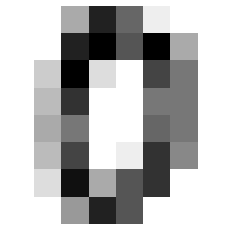

In [4]:
some_digit = X[0]
some_digit_image = some_digit.reshape(8, 8)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
y[0]

0

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Training a Binary Classifier

In [7]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) #Stochastic Gradient Descent Classifier
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

array([False])

# Performance Measures

## Accuracy

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle = True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) 

0.9791231732776617
0.9916492693110647
0.9958246346555324


In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.98121086, 0.98538622, 0.98956159])

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):  
    
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90605428, 0.90605428, 0.90605428])

## Confusion Matrix

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[1298,    4],
       [  17,  118]], dtype=int64)

In [15]:
from sklearn.metrics import precision_score, recall_score

print('La précision est de : ' + str(precision_score(y_train_5, y_train_pred)))
print('Le recall est de : ' + str(recall_score(y_train_5, y_train_pred)))

La précision est de : 0.9672131147540983
Le recall est de : 0.8740740740740741


In [16]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.9182879377431906

The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other con‐ texts you really care about recall.
\
\
For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a clas‐ sifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the clas‐ sifier’s video selection).
\
\
On the other hand, suppose you train a classifier to detect shoplifters on surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).
\
\
Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall tradeoff.


## Preicision/Recall Tradeoff

In [17]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [18]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                            
    plt.axis([-50000, 50000, 0, 1])             

In [19]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

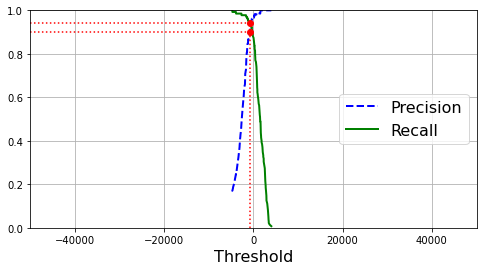

In [20]:
plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                           
plt.show()

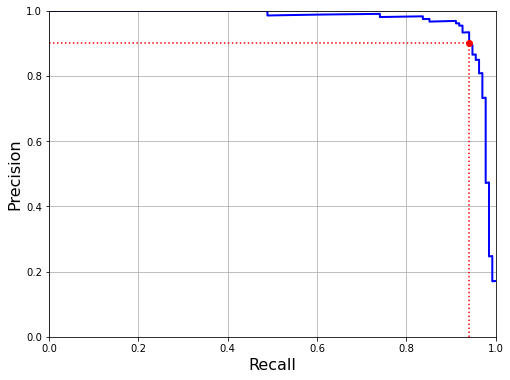

In [21]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

## ROC Curve

In [22]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

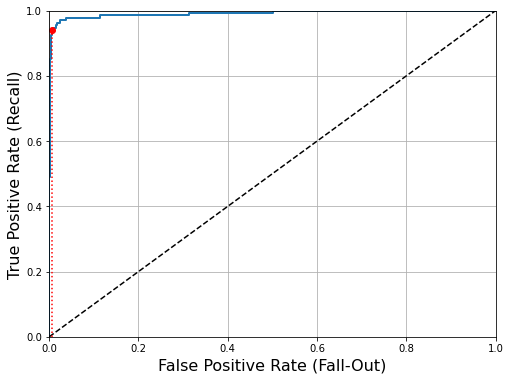

In [24]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                   
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")         

In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9916197303294076

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                     method="predict_proba")

In [27]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

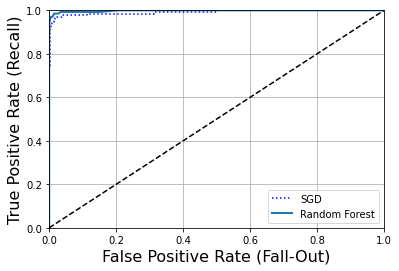

In [28]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [29]:
roc_auc_score(y_train_5, y_scores_forest)

0.9981765944131535

# MultiClass Classification

In [30]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([0])

In [31]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ 2526.95077122, -2904.58862349, -2859.84678851, -1902.43034813,
        -1456.64955425, -2460.83815085, -1867.42798836,  -421.68145365,
        -1290.16515015, -1037.21835373]])

In [32]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([0])

In [33]:
len(ovo_clf.estimators_)

45

In [34]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([0])

In [35]:
forest_clf.predict_proba([some_digit])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [36]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.9519833 , 0.95615866, 0.93319415])

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.93319415, 0.95824635, 0.91858038])

# Error Analysis

In [38]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[143,   0,   0,   0,   0,   0,   1,   0,   1,   0],
       [  0, 140,   0,   2,   0,   0,   1,   0,   7,   4],
       [  0,   1, 136,   2,   0,   0,   0,   1,   4,   0],
       [  0,   0,   0, 132,   0,   4,   0,   4,   8,   1],
       [  0,   4,   0,   0, 125,   0,   0,   1,   4,   1],
       [  0,   0,   0,   0,   0, 127,   0,   2,   3,   3],
       [  0,   1,   0,   0,   0,   0, 142,   0,   3,   0],
       [  0,   0,   0,   1,   2,   0,   0, 138,   3,   1],
       [  0,   7,   0,   2,   0,   0,   0,   0, 135,   0],
       [  0,   2,   0,   3,   0,   2,   0,   1,   4, 128]], dtype=int64)

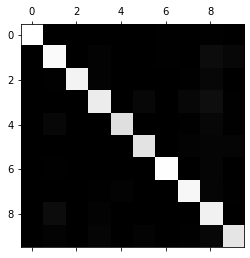

In [39]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

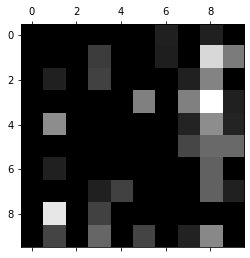

In [40]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [43]:
def plot_digits(instances, images_per_row=10, **options) :
    size = 8
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [44]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

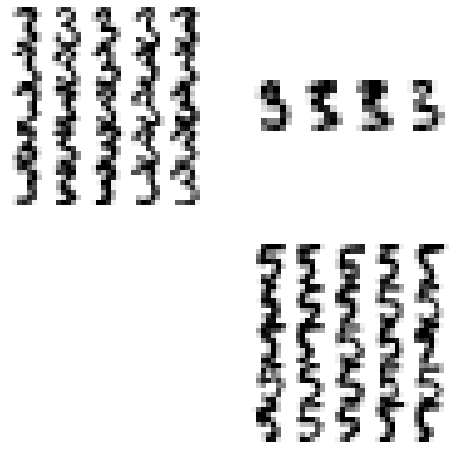

In [45]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
# plt.subplot(223); plot_digits(X_ba[:25], images_per_row=7)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# Multilabel Classification

In [46]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [47]:
knn_clf.predict([some_digit])

array([[False, False]])

In [48]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9802935564009936

# Multioutput Classifcation

In [49]:
noise = np.random.randint(0, 100, (len(X_train), 64))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 64))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [50]:
def plot_digit(data):
    image = data.reshape(8, 8)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

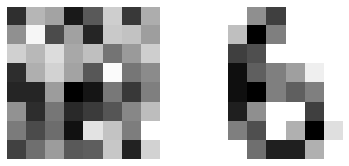

In [51]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

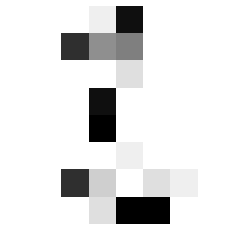

In [52]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)